Using and adding extra comments to example: https://medium.com/data-bistrot/a-simple-image-classifier-with-a-python-neural-network-82a5522fe48b

This uses CNNs with PyTorch and CIFAR-10

CIFAR-10 dataset: contains images from the following categories - planes, cars, birds, cats, etc.

First need to load CIFAR-10 dataset and organise.

In [ ]:
import torch #creates/trains models and performs tensor operations
import torchvision #gives popular datasets, model architectures and image processing stuff
import torchvision.transforms as transforms #helps preprocess images to help model use them
import matplotlib.pyplot as plt
import numpy as np

Further note on transforms: preprocessing images into a form that the model can work with. For example, converts images to 'tensors' and normalises their pixel values. Normalisation ensures each image has similar intensity ranges so that the model can learn more effectively across different images


**Next: Configuring Dataset configuration**

In [ ]:
batch_size = 10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch size = 10 means: we create subsets of data containing 10 images each. Then have the model learn based off each batch rather than handling the whole dataset at once.

transform pipeline contains:
transforms.ToTensor(): converts images to tensors - a data format that lets us work in PyTorch

transforms.Normalize(...): Normalises / adjusts RGB colour values to have a mean of 0 and standard deviation of 1 for each of the colours (red,green,blue).

the tuples (0.5,0.5,0.5) represent the mean and standard deviation for each colour channel. 0.5 is used because:

1. after applying transforms.ToTensor, the CIFAR-10 dataset has images with pixel values between 0 and 1. We want pixel values centred around 0 for the neural network, so we take 0.5 as the mean and standard deviation, to approximately normalise.

2. 0.5 is close enough to the actual means and standard deviation (rough approximation)

3. Efficiency for training.

**Downloading and loading CIFAR-10 Dataset**

In [ ]:
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

The above downloads and loads the CIFAR-10 dataset (and stores in local ./data folder?). Splits into training and testing set.

Then DataLoader streamlines the process of feeding images to the model:

First puts data into batches of 10 images. Using batches instead of individual images is quicker for updating model weights.

Shuffle = True means each batch of images is randomised. This means model generalises better, makes it less likely model overfits to any specific order of images (e.g if the dataset first had 20 images of bird, then 20 of plane etc.)

num_workers = 2 sets number of CPU threads used for data loading. ***WHAT ARE CPU THREADS?***

**Defining Classes**

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**Loading a batch of training images**



In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter) #slight modification here to account for python update

Creates an iterator for the trainloader and then retreives next batch of images and labels.

**Visualising images**

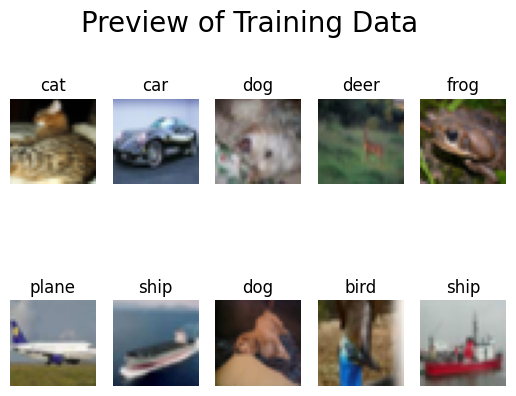

In [ ]:
for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i + 1) #creates subplots
    img = images[i] #extracts each image
    img = img / 2 + 0.5 #undoes normalisation to restore original colour range
    npimg = img.numpy() #convert tensor to numpy array so we can plot with matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #adjusts image dimensions (SEE CELL BELOW)
    plt.axis('off')
    plt.title(classes[labels[i]]) #labels subplots

plt.suptitle('Preview of Training Data', size=20)
plt.show()

Note on adjusting image dimensions: Pytorch images are in the format (channels, height, width) but matplotlib works with the format (height, width, channels). The transpose function deals with this.

We now have a good visualisation of the training data so we know what the model is working with.

**Define the neural network**

The above defines a CNN called 'Net' for image classification tasks. Let's break down what this is doing:

**Network architecture**

The first three lines:



```
class Net(nn.Module):
    def __init__(self):
        super().__init__()
```
define a CNN with 2 convolutional layers, 2 pooling layers and 3 fully connected layers.


**NOTE TO SELF: difference between these layers**

Convolutional layers:

suppose an image is a cuboid with length and width as the dimension of the image and height as the channel.

Now we take a small patch of the image and run a small NN, called a filter or kernel, to get K outputs and representing them vertically.

Now we slide the kernel across the whole image to get another image with different widths, heights and depths. Instead of just R,G,B channels we now have more channels but lesser width and height. This is called convolution.

The idea of convolution is to decrease the dimension of the image. Many more details in the description but quite involved: https://www.geeksforgeeks.org/machine-learning/introduction-convolution-neural-network/

**Overall layers structure:**

Input layers: image e.g 32x32x3

Convolutional layers: extracts feature from input dataset. applies kernels to input image(s). Kernels are generally smaller matrices e.g 3x3. Slides over input image data and computes dot product between kernel weight and the corresponding input image patch. Output of this layer is referred to as feature maps. Suppose we use 12 filters (kernels) for this layer - we would then get an output volume of dimension 32x32x12.

Activation layer: Adding an activation function to the output of the preceding layer adds nonlinearity to the network. e.g ReLU.

Pooling layer: periodically inserted in the CNN architecture (also called covnets). Main function is to reduce the size of the volume which speeds up the computation and prevents overfitting. Two common types of pooling layer are max pooling and average pooling. Max pool with 2x2 filters and stride 2 gives volume 16x16x12.

Flattening: Resulting feature maps are flattened into a one dimensional vector after the convolution and pooling layers so they can be passed into a completely linked layer for categorisation or regression.

Fully connected layers: takes input from previous lyer and computes the final classification or regression task.

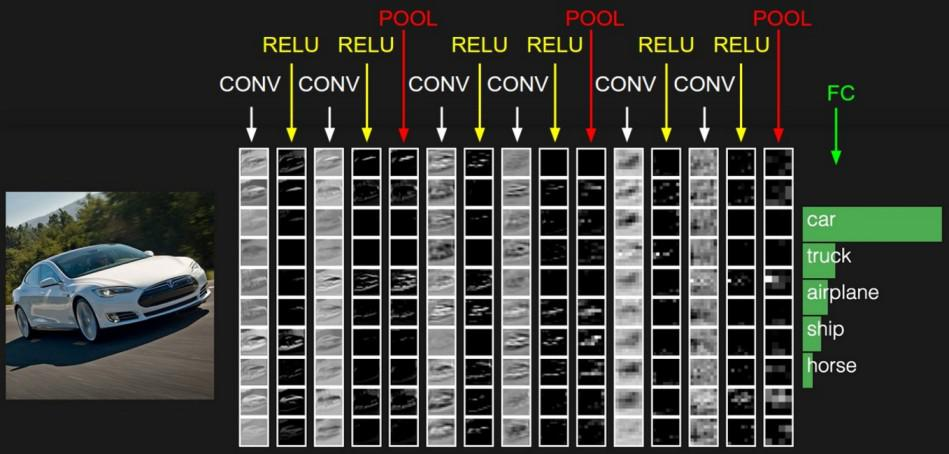

QUESTION: if colour channels are represented in one dimension (i.e RGB together only account for ONE variable), does that just mean the 'intensity' of the overall colour informs the CNN, rather than specifically what colour it is?

example above ^^

**Continuing with example FROM BEFORE**

Overall NN looks like this:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

the Net class defines the CNN with 2 convolutional layers, 2 pooling layers and 3 FC layers **Q: why would you want multiple FC layers if it gives the output?**



```
class Net(nn.Module):
    def __init__(self):
        super().__init__()
```
Class inherits from nn.Module, which is the 'base class' for all NN modules in PyTorch **base class meaning?**

init method 'initialises' the network's layers


**Layers**

First convolutional layer (conv1) looks like:



```
self.conv1 = nn.Conv2d(3, 6, 5)
```

which means there are 3 input channels (RGB colour channels), 6 'filters' (feature maps /kernels), and 5x5 kernel size (so each filter will be 5x5 pixels)

Note on filters: each filter is a small "window" that slides over the image and picks up specific patterns in the data. For example, one filter might detect horizontal lines while another would focus on vertical lines.

each filter here has a kernel size of 5x5 pixels, so captures localised patterns within this 25 pixel grid. NOTE TO SELF: when adapting to a different classification task, this might be an important thing to change!

**Pooling layer**



```
self.pool = nn.MaxPool2d(2, 2)
```

defines a max pooling layer. Max pooling reduces the spatial dimensions of each feature map while retaining the most important information. By summarising information, max pooling makes the network more efficient and less prone to overfitting.

The parameters (2,2) specify pooling kernel size and stride: kernel size means pooling layer looks at 2x2 regions, stride means pooling window moves 2 pixels at a time (therefore ensuring regions don't overlap)

In each 2x2 window, max pooling only keeps the maximum value (max value pixel or max value score?) and discards the rest. This reduces the overall data but also preserves features that stand out in each window.

**Second convolutional layer (conv2)**

the next convolutional layer has inputs 6,16,5 which corresponds to the output from the previous convolutional layer

**Fully connected layers**



```
self.fc1 = nn.Linear(16 * 5 * 5, 120)
self.fc2 = nn.Linear(120, 84)
self.fc3 = nn.Linear(84, 10)
```

After the convolutional and pooling layers, the image has passed through multiple stages of feature extraction, where its original spatial dimensions are reduced significantly. This new image contains the 'essential features' identified by the network. Now the network transitions to FC layers. These take the flattened output from the conv stages and treat it as a single array of features (no longer in a spatial grid).

Now the FC layers try to map the learned features to specific classes - i.e here it would be to 'plane','dog' etc.

fc1 layer: has 400 input features (16x5x5) and 120 output features. high number of features allows network to start forming a higher level understanding of the image
fc2 layer: 120 features condensed to 84
fc3 layer: outputs 10 values, each representing a class in CIFAR-10 dataset. Each value corresponds to the likelihood of the image belonging to one of the 10 classes.



**Forward pass**

In [ ]:
def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

The above 'forward pass' is the pathway that an image takes through each layer to produce a prediction. Each step builds on the previous one. Let's look at the first line:



```
x = self.pool(F.relu(self.conv1(x)))
```

This line passes the image through the first convolutional layer (conv1), then applies the ReLU activation function, before applying max pooling.

The next line is similar and we already outlined this process before.

Then we apply flattening with

```
x = torch.flatten(x, 1)
```
to convert it to a one dimensional array. Next the fully connected layers read

```
x = F.relu(self.fc1(x))
x = F.relu(self.fc2(x))
```
Which passes the data through two fully connected layers, each followed by ReLU. These layers learn relationships between the patterns extracted by the conv layers, to give a high level understanding of the image.

The final layer fc3 outputs raw scores for each class.


**Training the Neural Network**

**Prepare for Training**

In [ ]:
net = Net()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


print("Your network is ready for training!")

Your network is ready for training!


The above sets up the model, a loss function and an optimiser, so that we can train the network. Here's a further breakdown:


```
net = Net()
```
net creates an 'instance' our our neural network model Net. This model is like a "blank slate", as it has a learning framework set up but hasn't yet actually learnt from data.


```
criterion = nn.CrossEntropyLoss()
```
The above is the loss function. We use CrossEntropyLoss which is best for classification problems. The idea behind this function is to measure the difference between the models predictions and actual labels.



```
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
```
This sets up the 'optimiser', which updates weights and biases to reduce loss at each training step. Here we use stochastic gradient descent (SGD), which takes small steps in the direction that reduces the loss.

The learning rate (lr=0.001) controls step size. A small learning rate ensures gradual improvements, while momentum (momentum = 0.9) helps smooth out the updates, making the training more stable and efficient.




**Training and saving the model**

Now we move into the traning phase - the model learns to classify images by iterating through the dataset multiple times (also called 'epochs')

In [ ]:
from tqdm import tqdm

EPOCHS = 2
print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Save our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Training...


Epoch 2 of 2: 100%|█████████████████████████| 5000/5000 [00:51<00:00, 97.32it/s]


Let's break this down. First, we set the number of epochs to 2. Then we create a 'for' loop for each epoch:

We start by resetting running_loss to zero. This variable tracks the cumulative loss during each epoch, giving us an idea of how well the model is learning over time. NOTE TO SELF: this could be useful when deciding on a computational expense/overfitting vs accuracy optimisation - set epochs to the time when running loss starts to taper off quickly.

The inner loop processes each batch of images from the training set. The tqdm library gives a progress bar for each epoch, to monitor training progress (NOTE: and maybe track where it slows down?)

The next part is: **Forward Pass and Backpropagation**.



```
optimizer.zero_grad()
outputs = net(inputs)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()
```

First, optimizer.zero_grad() resets previous gradient values (otherwise pytorch includes prevous values).

outputs = net(inputs): the model makes predictions for the current batch, passing inputs through the network.

loss = criterion(outputs,labels): the loss function is calculated

loss.backward(): backpropagation calculates gradients of loss with respect to each parameter to inform how to change the model.

optimizer.step(): updates parameters accordingly, by one step





Then after training we save the model's state to a file. This can be reloaded later for testing or further training without having to wait for the model to retrain.

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

**Testing the model**

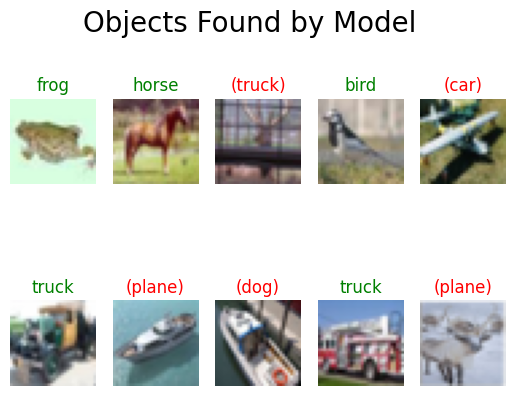

In [ ]:
# Pick random photos from training set
if dataiter == None:
    dataiter = iter(testloader)
images, labels = next(dataiter)

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

***Add explanation here!***

**Evaluating model accuracy**

In [ ]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 57.7 %
Accuracy for class: car   is 84.4 %
Accuracy for class: bird  is 38.4 %
Accuracy for class: cat   is 20.1 %
Accuracy for class: deer  is 43.2 %
Accuracy for class: dog   is 49.7 %
Accuracy for class: frog  is 69.0 %
Accuracy for class: horse is 51.3 %
Accuracy for class: ship  is 51.0 %
Accuracy for class: truck is 42.9 %
